In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
data=pd.read_excel('/content/drive/MyDrive/Capstone/data_fix_bersih_v5.xlsx')

In [ ]:
data.label.value_counts()

0    649
1    580
Name: label, dtype: int64

# Preprocessing

In [ ]:
!pip install Sastrawi

In [ ]:
import regex as re
import pandas as pd
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

#indonesian slang word
slang_word=pd.read_csv("/content/drive/MyDrive/Capstone/slang_word.txt", sep='\t')
slang_dict = dict(slang_word.values)

#Stopword
stopword = stopwords.words("indonesian")

with open("/content/drive/MyDrive/Capstone/not_stopword.txt") as l:
    not_stopword = l.read().splitlines()
    l.close()
stopword = set([word for word in stopword if word not in not_stopword])

#Stemming
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory=StemmerFactory()

stemmer=factory.create_stemmer()

def text_correction(text):
  correct_word = []
  for word in text.split():
      # searching from slang_dict
      correct_word.append(slang_dict.get(word, word))
  correct_word = ' '.join(correct_word)
  return correct_word
#preprocessing
def preprocessing(text):
      text=text.lower() #case folding
      #cleaning
      text=re.sub(r"\d+","",text)
      text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|\w+\.(com|id|org))','',text)
      text = re.sub('(\n|\n\n|\xa0)', ' ', text)
      text = re.sub('[•■®—«]', '', text)
      text=re.sub(r"(#|@)([^\s:]+)","",text) #remove tag account
      text = re.sub("[^\w\s]", " ", text) #remove punctuation, \w = alphanumeric, \s whitespace
      text=re.sub(" +", " ", text)
      text=re.sub("â€|ï","",text)
      text=re.sub("\u200d","",text)
      text=text_correction(text)
      text=stemmer.stem(text)
      text= ' '.join([word for word in text.split() if word not in (stopword)]) #remove stopword

      text=text.strip()
      return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
data['tweet_cleaned']=data['tweet'].apply(preprocessing)

In [ ]:
data['tweet_cleaned_2']=data['tweet'].apply(preprocessing)

In [ ]:
data

,tweet,label,tweet_cleaned,tweet_cleaned_2
0,[cm] halo aku butuh saran. jadi aku sedang nge...,1,butuh saran ngerjakan skripsi berat ngerjainny...,halo butuh saran ngerjakan skripsi berat bange...
1,today: dibilang managerku kl badanku kecil tp ...,1,today managerku badan pantat hamil sakit perut...,today managerku badanku pantatnya hamil sakit ...
2,Wajar cemas kalau ga dikasih kabar. Wajar gugu...,1,wajar cemas kabar wajar gugup hilang efek saya...,wajar cemas kabar wajar gugup menghilang efek ...
3,Gimana ya cara biar ngga cemas setiap abis mak...,1,biar cemas habis makan takut sayang kurus,iya biar cemas habis makan takut banget sayang...
4,Bau-bau mau anxiety lg wkwk,1,bau bau anxiety hahaha,bau bau anxiety hahaha
...,...,...,...,...
1220,"dia kelihatan capek, matanya sampai merah kare...",0,capek mata merah tidur malam,cape mata merah tidur malam
1221,capek banget ges,0,cape,cape
1222,"gua capek hidup njir, pengen bunuh diri",1,cape hidup bunuh diri,cape hidup bunuh diri
1223,sumpah capek bangetttt,0,cape,cape


In [ ]:
data.isnull().sum()

tweet              0
label              0
tweet_cleaned      4
tweet_cleaned_2    4
dtype: int64

In [ ]:
data=data.fillna('')

# Modelling (with stemming)

In [ ]:
!pip install fastText

In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D,GlobalMaxPooling1D,Dropout,Flatten
from keras.layers import Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import text
from keras.utils import to_categorical, pad_sequences
import fasttext

In [ ]:
texts=data.tweet_cleaned_2.values
labels=data['label'].values

MAX_NUM_WORDS = 5510 #di define sesuai jumlah unique token?
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 5510 unique tokens.


In [ ]:
#Save tokenizer to json agar compatible dgn tensorflow.js
import json
with open('/content/drive/MyDrive/Capstone/tensorflow_js/word2index.json', 'w') as fp:
    json.dump(word_index, fp)

In [ ]:
#data['doc_len'] = data['tweet_cleaned'].apply(lambda words: len(words.split(" ")))
#Mean_SEQUENCE_LENGTH = np.round(data['doc_len'].mean() + data['doc_len'].std()).astype(int)

data_x = pad_sequences(sequences, maxlen=30) #version 2 pakai 40, yg version 1 pakai 71
labels__=pd.get_dummies(labels).values

In [ ]:
print('Preparing embedding matrix.')

FT_MODEL = '/content/drive/MyDrive/Capstone/fasttext_twitter.vec'
EMBEDDING_DIM = 100

# load the fasttext model
f = fasttext.load_model(FT_MODEL)
#prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
  if i >= MAX_NUM_WORDS:
      continue
  embedding_vector = f.get_word_vector(word)
  if embedding_vector is not None:
      # words not found in embedding index will be all-zeros.
      embedding_matrix[i] = embedding_vector

In [ ]:
word = input("Enter word: ")
print(f'Is word "{word}" in model?', word in f)
print(f'Nearest neighbors of word "{word}":' )
f.get_nearest_neighbors(f'{word}')

Enter word: trauma
Is word "trauma" in model? True
Nearest neighbors of word "trauma":


[(0.7619697451591492, 'traumanya'),
 (0.6219233870506287, 'bullying'),
 (0.6054822206497192, 'gua,gue'),
 (0.6033239960670471, 'nempatin'),
 (0.5990766286849976, 'trainingnya'),
 (0.5907351970672607, 'bbrpa'),
 (0.5897470116615295, 'trio'),
 (0.5858281850814819, 'eak'),
 (0.5835475921630859, 'ngeganjel'),
 (0.5804108381271362, 'juga,gue')]

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data_x,labels__, test_size=0.1)

In [ ]:
np.unique(y_test, return_counts=True)

(array([0, 1], dtype=uint8), array([121, 121]))

In [ ]:
# load pre-trained word embeddings into an Embedding layer
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=30,
                            trainable=False)
# train a 1D convnet with global maxpooling
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(50, 2, activation='relu'))
model.add(GlobalMaxPooling1D())
#model.add(Dense(20, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

filepath="./weights_arsitektur2.best.hdf5"
es = EarlyStopping(monitor='val_accuracy', patience=30)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max',verbose=1)
callbacks_list = [es,checkpoint]

model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
#version 5
epochs=200
batch_size=24
history=model.fit(x_train, y_train, batch_size = batch_size, validation_data=(x_test, y_test),
                      epochs = epochs,callbacks=callbacks_list,verbose=1)

Epoch 1/200
46/47 [============================>.] - ETA: 0s - loss: 0.7541 - accuracy: 0.5136
Epoch 1: val_accuracy improved from -inf to 0.52846, saving model to ./weights_arsitektur2.best.hdf5
47/47 [==============================] - 3s 29ms/step - loss: 0.7537 - accuracy: 0.5145 - val_loss: 0.7196 - val_accuracy: 0.5285
Epoch 2/200
44/47 [===========================>..] - ETA: 0s - loss: 0.6963 - accuracy: 0.5691
Epoch 2: val_accuracy improved from 0.52846 to 0.56911, saving model to ./weights_arsitektur2.best.hdf5
47/47 [==============================] - 1s 16ms/step - loss: 0.6961 - accuracy: 0.5660 - val_loss: 0.6958 - val_accuracy: 0.5691
Epoch 3/200
45/47 [===========================>..] - ETA: 0s - loss: 0.6749 - accuracy: 0.6074
Epoch 3: val_accuracy improved from 0.56911 to 0.59350, saving model to ./weights_arsitektur2.best.hdf5
47/47 [==============================] - 0s 9ms/step - loss: 0.6755 - accuracy: 0.6058 - val_loss: 0.6842 - val_accuracy: 0.5935
Epoch 4/200
40/47

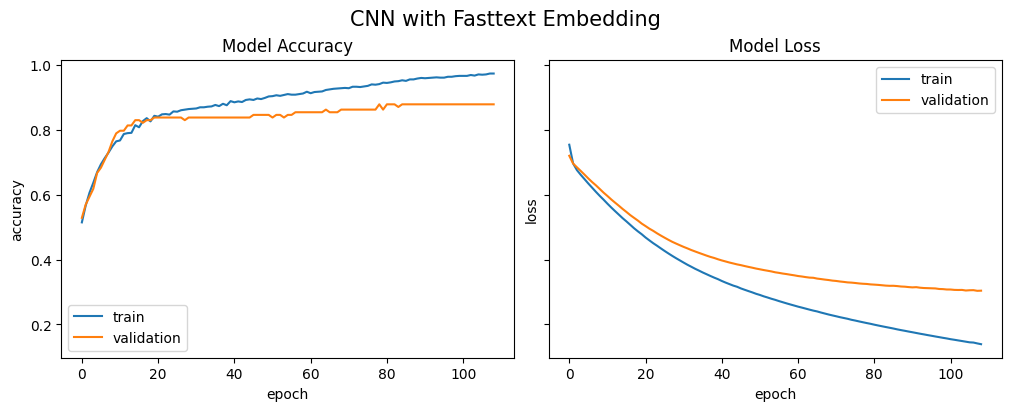

In [ ]:
#version 5
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''

    fig, ax = plt.subplots(1, 2, figsize=(10,4),constrained_layout=True, sharey=True)
    # first plot
    fig.suptitle('CNN with Fasttext Embedding', fontsize=15)
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')

plot_training_hist(history)

4/4 [==============================] - 0s 6ms/step


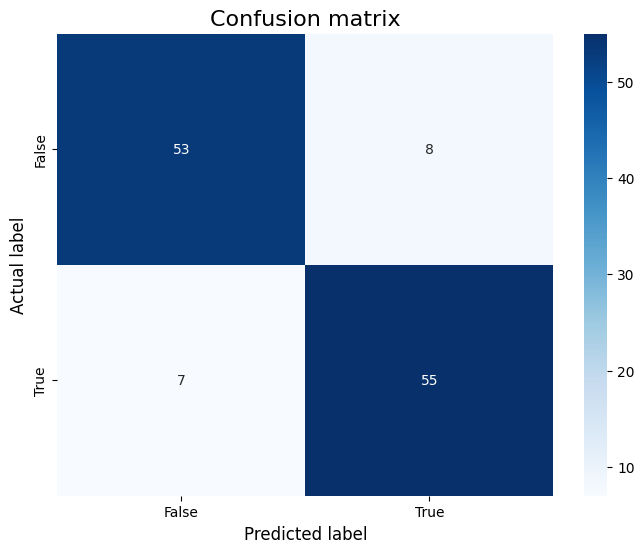

In [ ]:
#version 5
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''

    classes=['False','True']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d',
                xticklabels=classes,
                yticklabels=classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Predicted label', fontsize=12)
    plt.ylabel('Actual label', fontsize=12)

plot_confusion_matrix(model, x_test, y_test)

In [ ]:
!pip install tensorflowjs

In [ ]:
#Save model agar compatible dgn tensorflow.js
import tensorflow as tf
saved_model_path = '/content/drive/MyDrive/Capstone/tensorflow_js/Model_tfV5'
tf.saved_model.save(model, saved_model_path)

In [ ]:
!tensorflowjs_converter \
  --input_format=tf_saved_model \
  /content/drive/MyDrive/Capstone/tensorflow_js/Model \
  /content/drive/MyDrive/Capstone/tensorflow_js/modeljs

2023-06-13 03:44:43.916390: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
text="depresi"
text_cleaned=preprocessing(text)
print(text_cleaned)
word_seq = tokenizer.texts_to_sequences([text_cleaned])
word_pad = pad_sequences(word_seq,maxlen=30)
classes = ['Tidak Terindikasi Mental Illness', 'Terindikasi Mental Illness']
predicted_class=model.predict(word_pad).argmax(axis=1)
classes[predicted_class[0]]

depresi
1/1 [==============================] - 0s 26ms/step


'Terindikasi Mental Illness'

In [ ]:
text="alhamdulillah banyak bersyukur hari ini dapet banyak order"
text=preprocessing(text)
word_seq = tokenizer.texts_to_sequences([text])
word_pad = pad_sequences(word_seq,maxlen=30)
classes = ['Tidak Terindikasi Mental Illness', 'Terindikasi Mental Illness']
predicted_class=model.predict(word_pad).argmax(axis=1)
classes[predicted_class[0]]

1/1 [==============================] - 0s 75ms/step


'Tidak Terindikasi Mental Illness'

In [ ]:
text="yey aku dapet hadiah dari pacarku di valentine ini, mmm soswit"
text=preprocessing(text)
word_seq = tokenizer.texts_to_sequences([text])
word_pad = pad_sequences(word_seq,maxlen=30)
classes = ['Tidak Terindikasi Mental Illness', 'Terindikasi Mental Illness']
predicted_class=model.predict(word_pad).argmax(axis=1)
classes[predicted_class[0]]

1/1 [==============================] - 0s 120ms/step


'Tidak Terindikasi Mental Illness'

In [ ]:
text="gua hari ini self harm, kapan ya allah aku lepas dari semua penderitaan ini :("
text=preprocessing(text)
word_seq = tokenizer.texts_to_sequences([text])
word_pad = pad_sequences(word_seq,maxlen=30)
classes = ['Tidak Terindikasi Mental Illness', 'Terindikasi Mental Illness']
predicted_class=model.predict(word_pad).argmax(axis=1)
classes[predicted_class[0]]

1/1 [==============================] - 0s 21ms/step


'Terindikasi Mental Illness'

In [ ]:
text="depresi banget orang tuaku nggak ngehargai aku"
text=preprocessing(text)
word_seq = tokenizer.texts_to_sequences([text])
word_pad = pad_sequences(word_seq,maxlen=30)
classes = ['Tidak Terindikasi Mental Illness', 'Terindikasi Mental Illness']
predicted_class=model.predict(word_pad).argmax(axis=1)
classes[predicted_class[0]]

1/1 [==============================] - 0s 319ms/step


'Terindikasi Mental Illness'

In [ ]:
model_json = model.to_json()
with open("/content/drive/MyDrive/Capstone/model_CNN_v5.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to H5
model.save_weights("/content/drive/MyDrive/Capstone/model_CNN_v5.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
model.save('/content/drive/MyDrive/Capstone/saved_model_v5')

In [ ]:
import pickle

with open('/content/drive/MyDrive/Capstone/tokenizer_CNN_v5.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Saved tokenizer model to disk")

Saved tokenizer model to disk


## Load model

In [ ]:
#Load model
import pickle
from tensorflow.keras.models import model_from_json
from keras.utils import pad_sequences

# load json and create model
json_file = open("/content/drive/MyDrive/Capstone/model_CNN_v5.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/Capstone/model_CNN_v5.h5")
print("Loaded model from disk")

with open('/content/drive/MyDrive/Capstone/tokenizer_CNN_v5.pickle', 'rb') as handle:
    tokenizer_classification = pickle.load(handle)

Loaded model from disk


In [ ]:
text="capek"
text_cleaned=preprocessing(text)
word_seq = tokenizer_classification.texts_to_sequences([text_cleaned])
word_pad = pad_sequences(word_seq,maxlen=30)
classes = ['Tidak Terindikasi Mental Illness', 'Terindikasi Mental Illness']
predicted_class=loaded_model.predict(word_pad).argmax(axis=1)


print("Text: ",text)
print("Text cleaned: ",text_cleaned)
print("Label (Predicted): ",classes[predicted_class[0]])

1/1 [==============================] - 0s 24ms/step
Text:  capek
Text cleaned:  cape
Label (Predicted):  Tidak Terindikasi Mental Illness


In [ ]:
text="depresi banget orang tuaku nggak ngehargai aku"
text_cleaned=preprocessing(text)
word_seq = tokenizer_classification.texts_to_sequences([text_cleaned])
word_pad = pad_sequences(word_seq,maxlen=30)
classes = ['Tidak Terindikasi Mental Illness', 'Terindikasi Mental Illness']
predicted_class=loaded_model.predict(word_pad).argmax(axis=1)


print("Text: ",text)
print("Text cleaned: ",text_cleaned)
print("Label (Predicted): ",classes[predicted_class[0]])

1/1 [==============================] - 0s 32ms/step
Text:  depresi banget orang tuaku nggak ngehargai aku
Text cleaned:  depresi banget orang tua ngehargai
Label (Predicted):  Terindikasi Mental Illness


# Tanpa stemming

In [ ]:
epochs=20
batch_size=64
history=model.fit(x_train, y_train, batch_size = batch_size, validation_data=(x_test, y_test),
                  epochs = epochs)

Epoch 1/20
16/16 [==============================] - 2s 33ms/step - loss: 0.7788 - accuracy: 0.4663 - val_loss: 0.6969 - val_accuracy: 0.5575
Epoch 2/20
16/16 [==============================] - 0s 14ms/step - loss: 0.6879 - accuracy: 0.5635 - val_loss: 0.6625 - val_accuracy: 0.6460
Epoch 3/20
16/16 [==============================] - 0s 16ms/step - loss: 0.6449 - accuracy: 0.6925 - val_loss: 0.6379 - val_accuracy: 0.6991
Epoch 4/20
16/16 [==============================] - 0s 14ms/step - loss: 0.6090 - accuracy: 0.7738 - val_loss: 0.6066 - val_accuracy: 0.7434
Epoch 5/20
16/16 [==============================] - 0s 14ms/step - loss: 0.5738 - accuracy: 0.8115 - val_loss: 0.5783 - val_accuracy: 0.8053
Epoch 6/20
16/16 [==============================] - 0s 14ms/step - loss: 0.5396 - accuracy: 0.8522 - val_loss: 0.5514 - val_accuracy: 0.8230
Epoch 7/20
16/16 [==============================] - 0s 14ms/step - loss: 0.5047 - accuracy: 0.8651 - val_loss: 0.5225 - val_accuracy: 0.8407
Epoch 8/20
16

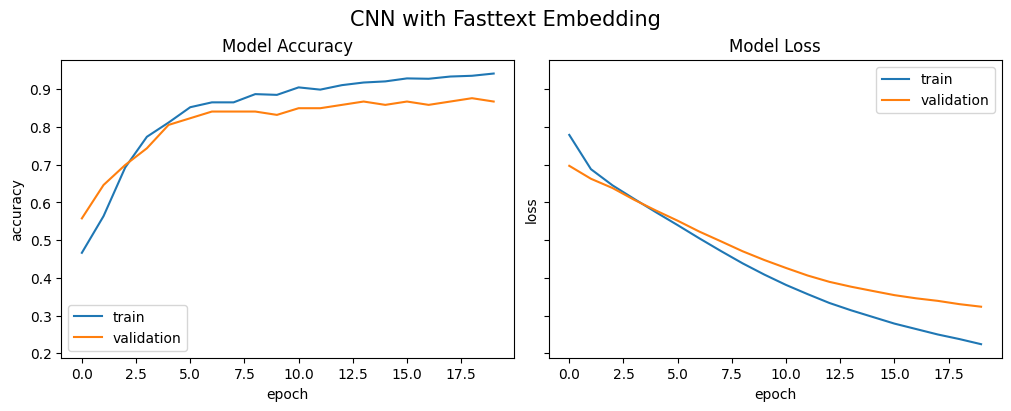

In [ ]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''

    fig, ax = plt.subplots(1, 2, figsize=(10,4),constrained_layout=True, sharey=True)
    # first plot
    fig.suptitle('CNN with Fasttext Embedding', fontsize=15)
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')

plot_training_hist(history)

4/4 [==============================] - 0s 6ms/step


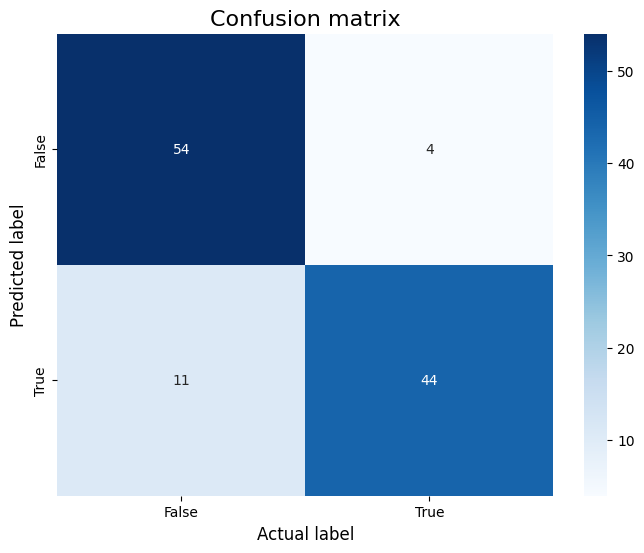

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''

    classes=['False','True']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d',
                xticklabels=classes,
                yticklabels=classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)

plot_confusion_matrix(model, x_test, y_test)

In [ ]:
text="alhamdulillah banyak bersyukur hari ini dapet banyak order"
text=preprocessing(text)
word_seq = tokenizer.texts_to_sequences([text])
word_pad = pad_sequences(word_seq,maxlen=Max_SEQUENCE_LENGTH)
classes = ['Tidak Terindikasi Mental Illness', 'Terindikasi Mental Illness']
predicted_class=model.predict(word_pad).argmax(axis=1)
classes[predicted_class[0]]

1/1 [==============================] - 0s 25ms/step


'Tidak Terindikasi Mental Illness'

In [ ]:
text="yey aku dapet hadiah dari pacarku di valentine ini, mmm soswit"
text=preprocessing(text)
word_seq = tokenizer.texts_to_sequences([text])
word_pad = pad_sequences(word_seq,maxlen=Max_SEQUENCE_LENGTH)
classes = ['Tidak Terindikasi Mental Illness', 'Terindikasi Mental Illness']
predicted_class=model.predict(word_pad).argmax(axis=1)
classes[predicted_class[0]]

1/1 [==============================] - 0s 39ms/step


'Tidak Terindikasi Mental Illness'

In [ ]:
text="gua hari ini self harm, kapan ya allah aku lepas dari semua penderitaan ini :("
text=preprocessing(text)
word_seq = tokenizer.texts_to_sequences([text])
word_pad = pad_sequences(word_seq,maxlen=Max_SEQUENCE_LENGTH)
classes = ['Tidak Terindikasi Mental Illness', 'Terindikasi Mental Illness']
predicted_class=model.predict(word_pad).argmax(axis=1)
classes[predicted_class[0]]

1/1 [==============================] - 0s 24ms/step


'Terindikasi Mental Illness'

In [ ]:
text="depresi banget orang tuaku nggak ngehargai aku"
text=preprocessing(text)
word_seq = tokenizer.texts_to_sequences([text])
word_pad = pad_sequences(word_seq,maxlen=Max_SEQUENCE_LENGTH)
classes = ['Tidak Terindikasi Mental Illness', 'Terindikasi Mental Illness']
predicted_class=model.predict(word_pad).argmax(axis=1)
classes[predicted_class[0]]

1/1 [==============================] - 0s 40ms/step


'Terindikasi Mental Illness'

In [ ]:
model_json = model.to_json()
with open("/content/drive/MyDrive/Capstone/model_CNN.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to H5
model.save_weights("/content/drive/MyDrive/Capstone/model_CNN.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
import pickle

with open('/content/drive/MyDrive/Capstone/tokenizer_CNN.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Saved tokenizer model to disk")

Saved tokenizer model to disk


# arsitektur 2

In [ ]:
# load pre-trained word embeddings into an Embedding layer
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=Max_SEQUENCE_LENGTH,
                            trainable=False)
# train a 1D convnet with global maxpooling
model_2 = Sequential()
model_2.add(embedding_layer)
model_2.add(Conv1D(64, 5, activation='relu'))
model_2.add(Conv1D(32,5,activation='relu'))
model_2.add(Dropout(0.2))
model_2.add(MaxPooling1D()),
model_2.add(Flatten())
model_2.add(Dense(32, activation='relu')),
model_2.add(Dense(2, activation='sigmoid'))

filepath="./weights_arsitektur2.best.hdf5"

es = EarlyStopping(monitor='val_accuracy', patience=10)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max',verbose=1)
callbacks_list = [es,checkpoint]

model_2.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
epochs=50
batch_size=64
history_2=model_2.fit(x_train, y_train, batch_size = batch_size, validation_data=(x_test, y_test),
                      epochs = epochs,callbacks=callbacks_list,verbose=1)

Epoch 1/50
15/16 [===========================>..] - ETA: 0s - loss: 0.6746 - accuracy: 0.6323
Epoch 1: val_accuracy improved from -inf to 0.72566, saving model to ./weights_arsitektur2.best.hdf5
16/16 [==============================] - 2s 54ms/step - loss: 0.6723 - accuracy: 0.6329 - val_loss: 0.6041 - val_accuracy: 0.7257
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 0.5589 - accuracy: 0.7173
Epoch 2: val_accuracy improved from 0.72566 to 0.83186, saving model to ./weights_arsitektur2.best.hdf5
16/16 [==============================] - 1s 41ms/step - loss: 0.5589 - accuracy: 0.7173 - val_loss: 0.4319 - val_accuracy: 0.8319
Epoch 3/50
15/16 [===========================>..] - ETA: 0s - loss: 0.3932 - accuracy: 0.8250
Epoch 3: val_accuracy improved from 0.83186 to 0.85841, saving model to ./weights_arsitektur2.best.hdf5
16/16 [==============================] - 1s 40ms/step - loss: 0.3907 - accuracy: 0.8274 - val_loss: 0.3170 - val_accuracy: 0.8584
Epoch 4/50
15/16 [=

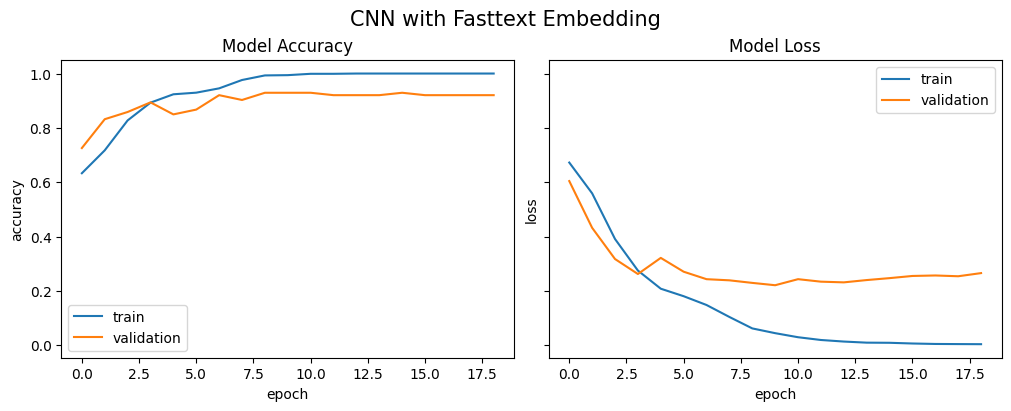

In [ ]:
plot_training_hist(history_2)

In [ ]:
text="alhamdulillah banyak bersyukur hari ini dapet banyak order"
text=preprocessing(text)
word_seq = tokenizer.texts_to_sequences([text])
word_pad = pad_sequences(word_seq,maxlen=Max_SEQUENCE_LENGTH)
classes = ['Tidak Terindikasi Mental Illness', 'Terindikasi Mental Illness']
predicted_class=model.predict(word_pad).argmax(axis=1)
classes[predicted_class[0]]

1/1 [==============================] - 0s 27ms/step


'Terindikasi Mental Illness'

In [ ]:
text="depresi banget orang tuaku nggak ngehargai aku"
text=preprocessing(text)
word_seq = tokenizer.texts_to_sequences([text])
word_pad = pad_sequences(word_seq,maxlen=Max_SEQUENCE_LENGTH)
classes = ['Tidak Terindikasi Mental Illness', 'Terindikasi Mental Illness']
predicted_class=model.predict(word_pad).argmax(axis=1)
classes[predicted_class[0]]

1/1 [==============================] - 0s 39ms/step


'Terindikasi Mental Illness'

In [ ]:
text="yey aku dapet hadiah dari pacarku di valentine ini, mmm soswit"
text=preprocessing(text)
word_seq = tokenizer.texts_to_sequences([text])
word_pad = pad_sequences(word_seq,maxlen=Max_SEQUENCE_LENGTH)
classes = ['Tidak Terindikasi Mental Illness', 'Terindikasi Mental Illness']
predicted_class=model.predict(word_pad).argmax(axis=1)
classes[predicted_class[0]]

1/1 [==============================] - 0s 23ms/step


'Terindikasi Mental Illness'

model jelek karena lossnya semakin naik